# Neural differential solver
Implementation and analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader
from typing import List, Callable

## Implementation
Neural differential solver functionality:

In [2]:
class DNN(nn.Module):
    def __init__(self, input_shape: int, hidden_shapes: List[int], output_shape: int, activations: List[Callable] = None):
        super(DNN, self).__init__()
        depth = len(hidden_shapes)
        if activations is None:
            activations = [nn.Sigmoid() for _ in range(depth)]  # sigmoid as default
        else:
            assert len(activations) == depth
        layers = []
        layers.append(nn.Linear(input_shape, hidden_shapes[0]))
        layers.append(activations[0])
        for layer_i in range(1, depth):
            layers.append(nn.Linear(hidden_shapes[layer_i-1], hidden_shapes[layer_i]))
            layers.append(activations[layer_i])
        layers.append(nn.Linear(hidden_shapes[-1], output_shape))
        self.model = nn.Sequential(*layers)  # unpack list by `*list`

    def forward(self, x: torch.Tensor):
        return self.model(x)


# TODO Explore including convolutional layers to the network
class ConvDNN(nn.Module):
    def __init__(self, input_shape: int, hidden_shapes: List[int], output_shape: int, activations: List[Callable] = None):
        super(DNN, self).__init__()
        depth = len(hidden_shapes)
        if activations is None:
            activations = [nn.Sigmoid() for _ in range(depth)]  # sigmoid as default
        else:
            assert len(activations) == depth
        layers = []
        layers.append(nn.Linear(input_shape, hidden_shapes[0]))
        layers.append(activations[0])
        for layer_i in range(1, depth):
            layers.append(nn.Linear(hidden_shapes[layer_i-1], hidden_shapes[layer_i]))
            layers.append(activations[layer_i])
        layers.append(nn.Linear(hidden_shapes[-1], output_shape))
        self.model = nn.Sequential(*layers)  # unpack list by `*list`

    def forward(self, x: torch.Tensor):
        return self.model(x)


def calcGradients(function, x, order):
    if order == 0:
        return function(x)
    y = function(x)
    grad = torch.autograd.grad(outputs=y, inputs=x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    for _ in range(1, order):
        grad = torch.autograd.grad(outputs=grad, inputs=x, grad_outputs=torch.ones_like(grad), create_graph=True)[0]
    return grad


class LossFunction(nn.Module):
    def __init__(self, differential_expressions: List[Callable], bc_grad_orders: List[int], 
                 bc_functions: list[Callable], bc_boundaries: List[float], ):
        super(LossFunction, self).__init__()
        self.differential_expressions = differential_expressions
        self.problem_order = len(bc_boundaries)
        self.bc_grad_orders = bc_grad_orders
        self.bc_functions = bc_functions
        bc_boundaries_temp = [float(b) for b in bc_boundaries]
        self.bc_boundaries = torch.tensor(bc_boundaries_temp, requires_grad=True)
        assert self.problem_order == len(self.bc_grad_orders) and self.problem_order == len(self.bc_functions)

    def _calcBoundaryCondition(self, model: nn.Module, x_data: torch.Tensor, include_all_bc: bool):
        bc_terms = []
        for bc_i in range(self.problem_order):
            bc_boundary = self.bc_boundaries[bc_i]
            # NB bc_boundary is tensor. Does `x_data == bc_boundary` in this case?
            bc_boundary_inds = (x_data == bc_boundary).nonzero()
            if bc_boundary_inds.numel() > 0:
                x_bc = x_data[bc_boundary_inds[0,0]]
                term1 = calcGradients(model, x_bc, self.bc_grad_orders[bc_i])  # grad_x^p_i model(x_{b_i})
                term2 = self.bc_functions[bc_i](x_bc)  # K_i(x_{p_i})
                if not isinstance(term2, torch.Tensor): 
                    term2 = torch.tensor([term2], requires_grad=True)  # Make sure term2 is tensor which grad is tracked
                # QUESTION If the function `bc_functions[bc_i]` returns a constant, does it matter if the (newly created) 
                # tensor tracks the gradient or not?
                bc_term_i = (term1 - term2)**2
                bc_terms.append(bc_term_i)
        if len(bc_terms) == 0:
            return torch.tensor(0.0, requires_grad=True)
        else:
            return torch.sum(torch.stack(bc_terms))

    def __call__(self, model: nn.Module, x_data: torch.Tensor, include_all_bc: bool = False):
        x_max = x_data.shape[0]
        F_term = self.differential_expressions(model, x_data).square().sum() / x_max
        bc_term = self._calcBoundaryCondition(model, x_data, include_all_bc)
        return F_term + bc_term



def genDataLoader(domain, discretization, batch_size=None, batch_shuffle=False):
    assert isinstance(domain, list) and all(isinstance(d, list) and len(d)==2 for d in domain), \
        "`domain` should be a list of lists all with two floats for lower and higher boundry of the dimension."
    ranges = [np.arange(d[0], d[1], discretization) for d in domain]
    grid = np.meshgrid(*ranges)
    x = np.stack([g.flatten() for g in grid], axis=-1)
    x_tensor = torch.from_numpy(x).float().requires_grad_(True)
    if batch_size is None:
        batch_size = len(x)
    dataloader = DataLoader(x_tensor, batch_size=batch_size, shuffle=batch_shuffle)
    return dataloader


def training(model, loss_fn, dataloader, num_epochs, learning_rate, save_model_freq=None, save_model_path=None):
    if (save_model_path is not None) and (save_model_freq is None):
        raise TypeError("`save_model_path` is not defined while `save_model_freq` is given.")
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []

    model.train()  # Make sure to be in train mode
    for epoch_i in range(num_epochs):
        running_loss = 0.0
        for batch_i, batch_x in enumerate(dataloader):
            # Input data in appropriate shape
            batch_x = batch_x.unsqueeze(-1)
            # NB no need to specifically calculate forward push
            # Backpropagation
            optimizer.zero_grad()
            loss = loss_fn(model, batch_x)
            loss.backward()
            optimizer.step()
            # Keep track of loss
            running_loss += loss.item()
        
        # Potentially save the model at a given intervals
        if save_model_freq is not None:
            if (epoch_i + 1) % save_model_freq == 0:
                torch.save(model.state_dict(), "{}/epoch_{}.pth".format(save_model_path, epoch_i+1))

        loss_history.append(running_loss)
        # Print progress
        print("Epoch {}/{} Loss: {:.4f}". format(epoch_i+1, num_epochs, running_loss))

    return loss_history


def traininigDomainExtension(model, loss_fn, domains, discretization, num_epochs_per_domain, learning_rate, 
                             save_model_freq=None, save_model_path=None, eval_function=None, eval_freq=1):
    if (save_model_path is not None) and (save_model_freq is None):
        raise TypeError("`save_model_path` is not defined while `save_model_freq` is given.")
    
    num_domains = len(domains)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []
    eval_history = {}  # {epoch: eval function result}
    for domain_i, domain in enumerate(domains):
        dataloader = genDataLoader(domain, discretization)

        model.train()  # Make sure to be in train mode
        for epoch_i in range(num_epochs_per_domain):
            running_loss = 0.0
            for batch_i, batch_x in enumerate(dataloader):
                # Input data in appropriate shape
                batch_x = batch_x.unsqueeze(-1)
                # NB no need to specifically calculate forward push
                # Backpropagation
                optimizer.zero_grad()
                loss = loss_fn(model, batch_x)
                loss.backward()
                optimizer.step()
                # Keep track of loss
                running_loss += loss.item()
            
            # Potentially save the model at a given intervals
            if save_model_freq is not None:
                if (epoch_i + 1) % save_model_freq == 0:
                    torch.save(model.state_dict(), "{}/epoch_{}.pth".format(save_model_path, epoch_i+1))

            loss_history.append(running_loss)
            # Print progress
            print("Domain {}/{}, Epoch {}/{} Loss: {:.4f}". format(domain_i+1, num_domains, epoch_i+1, 
                                                                   num_epochs_per_domain, running_loss))
            
            # DEBUGGING
            if eval_function is not None:
                if epoch_i % eval_freq == 0:
                    model.eval()
                    # TODO Ability to evaluate current model with a given function (e.g. the correct/analytic solution)
                    # NB remember to then also return the evaluation data alongside with `loss_history`.
                    model.train()
                    pass
            

    return loss_history
        

## Example 1
Solve $f'(x) - x - 1 = 0$ with boundary condition $f(0) = 0$ on $x \in [0,\infty]$. Analytic solution is $f(x) = x^2 / 2 + x + c$ where now $c = 0$.

Epoch 1/100 Loss: 4.3173
Epoch 2/100 Loss: 2.9950
Epoch 3/100 Loss: 1.7196
Epoch 4/100 Loss: 0.6653
Epoch 5/100 Loss: 0.6466
Epoch 6/100 Loss: 0.8539
Epoch 7/100 Loss: 0.9127
Epoch 8/100 Loss: 0.5938
Epoch 9/100 Loss: 0.4715
Epoch 10/100 Loss: 0.2969
Epoch 11/100 Loss: 0.3618
Epoch 12/100 Loss: 0.4535
Epoch 13/100 Loss: 0.4183
Epoch 14/100 Loss: 0.3298
Epoch 15/100 Loss: 0.2435
Epoch 16/100 Loss: 0.1978
Epoch 17/100 Loss: 0.2275
Epoch 18/100 Loss: 0.2117
Epoch 19/100 Loss: 0.1872
Epoch 20/100 Loss: 0.1527
Epoch 21/100 Loss: 0.1253
Epoch 22/100 Loss: 0.1304
Epoch 23/100 Loss: 0.1250
Epoch 24/100 Loss: 0.1072
Epoch 25/100 Loss: 0.0867
Epoch 26/100 Loss: 0.0730
Epoch 27/100 Loss: 0.0756
Epoch 28/100 Loss: 0.0620
Epoch 29/100 Loss: 0.0479
Epoch 30/100 Loss: 0.0426
Epoch 31/100 Loss: 0.0411
Epoch 32/100 Loss: 0.0307
Epoch 33/100 Loss: 0.0258
Epoch 34/100 Loss: 0.0214
Epoch 35/100 Loss: 0.0167
Epoch 36/100 Loss: 0.0134
Epoch 37/100 Loss: 0.0100
Epoch 38/100 Loss: 0.0176
Epoch 39/100 Loss: 0.

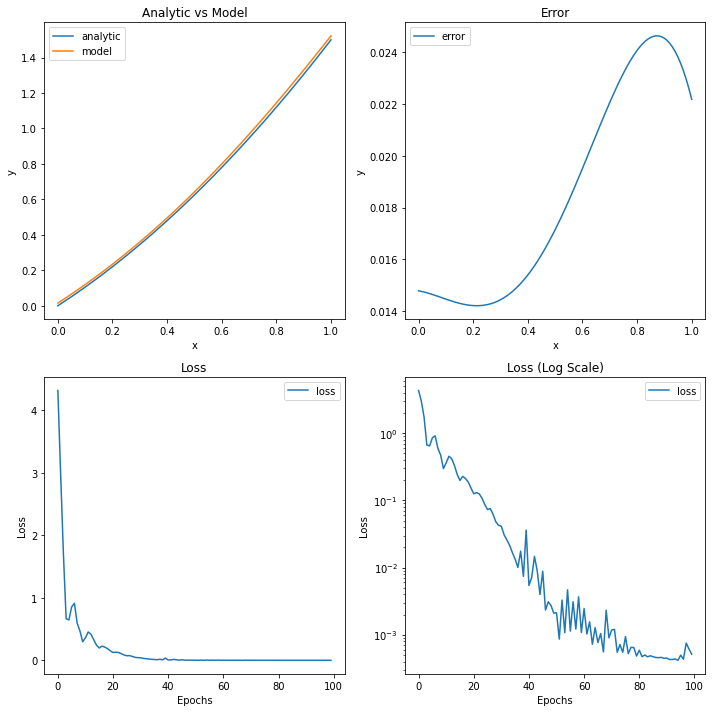

In [3]:
# --- Problem definitions ---
def equation(f, x):
    f_prime = calcGradients(f, x, 1)
    return f_prime - x - 1

def bc_function_1(x):
    return 0.0

bc_functions = [bc_function_1]
bc_ps = [0]
bc_xs = [0.0]

x_min = 0.0
x_max = 1.0


# --- Solver input definitions ---
# Loss
loss_fn = LossFunction(equation, bc_ps, bc_functions, bc_xs)

# Domain specification
discretization = 0.01
batch_size = 50
batch_shuffle = True

x = np.arange(x_min, x_max, discretization)
x_tensor = torch.from_numpy(x).float().requires_grad_(True)
dataloader = DataLoader(x_tensor, batch_size=batch_size, shuffle=batch_shuffle)

# Model
hidden_shapes = [100, 100]
input_shape = 1
output_shape = 1
model = DNN(input_shape, hidden_shapes, output_shape)

# Training
num_epochs = 100
learning_rate = 0.01


# --- Running solver ---
loss_data = training(model, loss_fn, dataloader, num_epochs, learning_rate)


# --- Result visualization
def equation_analytic(x):
    return x**2 * 0.5 + x

model.eval()
x_eval = np.linspace(0,1,100)
y_analytic = equation_analytic(x_eval)
x_eval_tensor = torch.from_numpy(x_eval).float().unsqueeze(-1)
y_model = model(x_eval_tensor).detach().flatten().numpy()

y_error = y_model - y_analytic

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Analytic vs Model
axs[0, 0].plot(x_eval, y_analytic, label="analytic")
axs[0, 0].plot(x_eval, y_model, label="model")
axs[0, 0].legend()
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")
axs[0, 0].set_title("Analytic vs Model")

# Error
axs[0, 1].plot(x_eval, y_error, label="error")
axs[0, 1].legend()
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")
axs[0, 1].set_title("Error")

# Loss
axs[1, 0].plot(loss_data, label="loss")
axs[1, 0].legend()
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].set_title("Loss")

# Loss (Log Scale)
axs[1, 1].plot(loss_data, label="loss")
axs[1, 1].set_yscale("log")
axs[1, 1].legend()
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].set_title("Loss (Log Scale)")

plt.tight_layout()
plt.show()

## Example 2
Solve f''(x) - f'(x) + f(x) - 1 = 0 which has analytic solution $f(x) = c_2 e^{x/2} \sin(\sqrt{3} x / 2) + c_1 e^{x/2} \cos(\sqrt{3} x / 2) + 1$. For domain $x \in [0, 10]$ with boundary conditions $f(0) = 0$ and $f(10) = 0$ you have $c_1 = -1$, $c_2 = \frac{\csc \left(5 \sqrt{3}\right)-e^5 \cot \left(5 \sqrt{3}\right)}{e^5}$.

Epoch 1/1000 Loss: 4.6451
Epoch 2/1000 Loss: 0.8557
Epoch 3/1000 Loss: 1.9076
Epoch 4/1000 Loss: 0.7925
Epoch 5/1000 Loss: 1.2699
Epoch 6/1000 Loss: 0.8833
Epoch 7/1000 Loss: 1.0347
Epoch 8/1000 Loss: 0.8936
Epoch 9/1000 Loss: 0.9251
Epoch 10/1000 Loss: 0.8350
Epoch 11/1000 Loss: 0.8393
Epoch 12/1000 Loss: 0.7645
Epoch 13/1000 Loss: 0.7738
Epoch 14/1000 Loss: 0.7923
Epoch 15/1000 Loss: 0.8244
Epoch 16/1000 Loss: 0.7629
Epoch 17/1000 Loss: 0.8980
Epoch 18/1000 Loss: 0.8892
Epoch 19/1000 Loss: 0.8034
Epoch 20/1000 Loss: 0.8834
Epoch 21/1000 Loss: 0.8259
Epoch 22/1000 Loss: 0.9038
Epoch 23/1000 Loss: 1.0924
Epoch 24/1000 Loss: 0.8082
Epoch 25/1000 Loss: 0.8204
Epoch 26/1000 Loss: 0.7851
Epoch 27/1000 Loss: 0.7689
Epoch 28/1000 Loss: 0.9288
Epoch 29/1000 Loss: 0.9319
Epoch 30/1000 Loss: 0.8210
Epoch 31/1000 Loss: 0.8148
Epoch 32/1000 Loss: 0.8411
Epoch 33/1000 Loss: 0.9583
Epoch 34/1000 Loss: 1.1113
Epoch 35/1000 Loss: 0.8106
Epoch 36/1000 Loss: 0.7984
Epoch 37/1000 Loss: 0.7392
Epoch 38/1

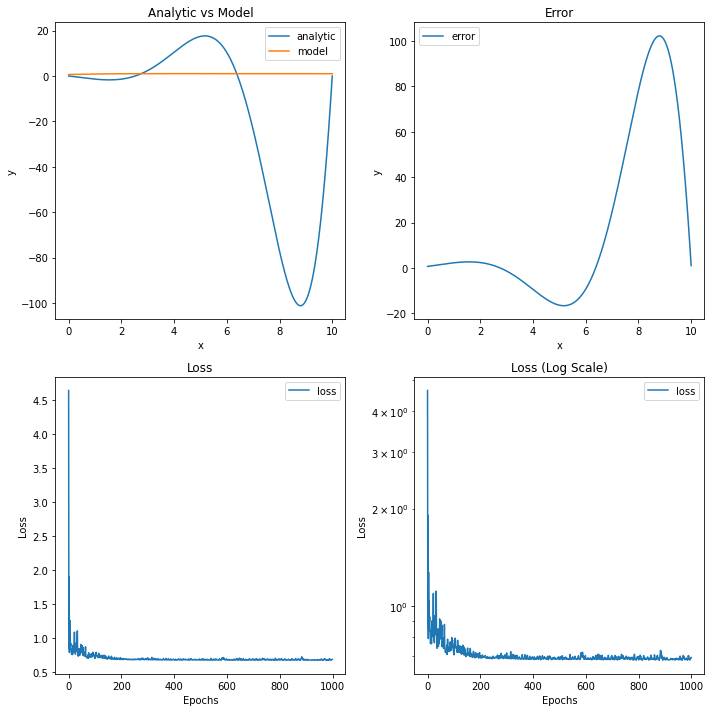

In [23]:
# --- Problem definitions ---
def equation(f, x):
    grad2_fx = calcGradients(f, x, 2)
    grad1_fx = calcGradients(f, x, 1)
    fx = f(x)
    return grad2_fx - grad1_fx + fx - 1

def bc_function_1(x):
    return 0.0

def bc_function_2(x):
    return 0.0

bc_functions = [bc_function_1, bc_function_2]
bc_ps = [0, 0]
bc_xs = [0.0, 10.0]

x_min = 0.0
x_max = 10.0


# --- Solver input definitions ---
# Loss
loss_fn = LossFunction(equation, bc_ps, bc_functions, bc_xs)

# Domain specification
discretization = 0.01
batch_size = 100
batch_shuffle = False

x = np.arange(x_min, x_max, discretization)
x_tensor = torch.from_numpy(x).float().requires_grad_(True)
dataloader = DataLoader(x_tensor, batch_size=batch_size, shuffle=batch_shuffle)

# Model
hidden_shapes = [500, 200, 100]
input_shape = 1
output_shape = 1
model = DNN(input_shape, hidden_shapes, output_shape)

# Training
num_epochs = 1000
learning_rate = 0.01


# --- Running solver ---
loss_data = training(model, loss_fn, dataloader, num_epochs, learning_rate)


# --- Result visualization
def equation_analytic(x):
    c1 = -1
    c2 = -1/(np.exp(5)*np.sin(5*np.sqrt(3))) + np.cos(5*np.sqrt(3))/np.sin(5*np.sqrt(3))
    cos_term = c1*np.cos(np.sqrt(3)*x/2)
    sin_term = c2*np.sin(np.sqrt(3)*x/2)
    return 1 + np.exp(x/2)*(cos_term + sin_term)

model.eval()
x_eval = np.linspace(x_min,x_max,1000)
y_analytic = equation_analytic(x_eval)
x_eval_tensor = torch.from_numpy(x_eval).float().unsqueeze(-1)
y_model = model(x_eval_tensor).detach().flatten().numpy()

y_error = y_model - y_analytic

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot 1: Analytic vs Model
axs[0, 0].plot(x_eval, y_analytic, label="analytic")
axs[0, 0].plot(x_eval, y_model, label="model")
axs[0, 0].legend()
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")
axs[0, 0].set_title("Analytic vs Model")

# Plot 2: Error
axs[0, 1].plot(x_eval, y_error, label="error")
axs[0, 1].legend()
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")
axs[0, 1].set_title("Error")

# Plot 3: Loss
axs[1, 0].plot(loss_data, label="loss")
axs[1, 0].legend()
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].set_title("Loss")

# Plot 4: Loss (Log Scale)
axs[1, 1].plot(loss_data, label="loss")
axs[1, 1].set_yscale("log")
axs[1, 1].legend()
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].set_title("Loss (Log Scale)")

plt.tight_layout()
plt.show()

## Example 3
Solve $f''(x)+f'(x)+f(x)-x^2+1=0$ in the domain $x \in [0,5]$ with boundary conditions $f(0) = 0$ and $f(5) = -1$. Analytic solution is 
$$
f(x) = x^2-2 x+e^{-x/2} \cos \left(\frac{\sqrt{3} x}{2}\right)-e^{-x/2} \left(15 e^{5/2}+\cos
   \left(\frac{5 \sqrt{3}}{2}\right)\right) \csc \left(\frac{5 \sqrt{3}}{2}\right) \sin
   \left(\frac{\sqrt{3} x}{2}\right)-1
$$

Epoch 1/2000 Loss: 110.2752
Epoch 2/2000 Loss: 170.8584
Epoch 3/2000 Loss: 127.8234
Epoch 4/2000 Loss: 90.2375
Epoch 5/2000 Loss: 87.3044
Epoch 6/2000 Loss: 99.0579
Epoch 7/2000 Loss: 97.8749
Epoch 8/2000 Loss: 102.3540
Epoch 9/2000 Loss: 100.1045
Epoch 10/2000 Loss: 97.4361
Epoch 11/2000 Loss: 94.9873
Epoch 12/2000 Loss: 92.9786
Epoch 13/2000 Loss: 91.4706
Epoch 14/2000 Loss: 85.7673
Epoch 15/2000 Loss: 84.8098
Epoch 16/2000 Loss: 84.1800
Epoch 17/2000 Loss: 90.2471
Epoch 18/2000 Loss: 90.5193
Epoch 19/2000 Loss: 82.9998
Epoch 20/2000 Loss: 89.9166
Epoch 21/2000 Loss: 89.1693
Epoch 22/2000 Loss: 88.3953
Epoch 23/2000 Loss: 81.1371
Epoch 24/2000 Loss: 81.3114
Epoch 25/2000 Loss: 87.6999
Epoch 26/2000 Loss: 81.3269
Epoch 27/2000 Loss: 87.5090
Epoch 28/2000 Loss: 87.3667
Epoch 29/2000 Loss: 87.2720
Epoch 30/2000 Loss: 79.8807
Epoch 31/2000 Loss: 87.3277
Epoch 32/2000 Loss: 79.3719
Epoch 33/2000 Loss: 79.2274
Epoch 34/2000 Loss: 79.1018
Epoch 35/2000 Loss: 87.8859
Epoch 36/2000 Loss: 78.6

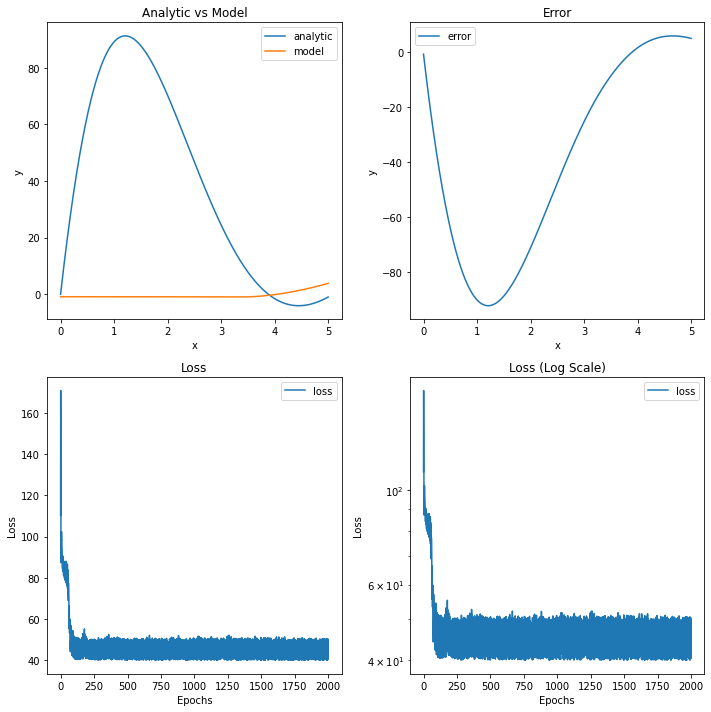

In [22]:
# --- Problem definitions ---
def equation(f, x):
    grad2_fx = calcGradients(f, x, 2)
    grad1_fx = calcGradients(f, x, 1)
    fx = f(x)
    return grad2_fx + grad1_fx + fx - x**2 + 1

def bc_function_1(x):
    return 0.0

def bc_function_2(x):
    return -1.0

bc_functions = [bc_function_1, bc_function_2]
bc_ps = [0, 0]
bc_xs = [0.0, 5.0]

x_min = 0.0
x_max = 5.0


# --- Solver input definitions ---
# Loss
loss_fn = LossFunction(equation, bc_ps, bc_functions, bc_xs)

# Domain specification
# discretization = 0.05
num_discretization = 500
batch_size = 500
batch_shuffle = True

# x = np.arange(x_min, x_max, discretization)  # NB x_max is not included in arange!
x = np.linspace(x_min, x_max, num_discretization)  # x_max is included in linspace!
x_tensor = torch.from_numpy(x).float().requires_grad_(True)
dataloader = DataLoader(x_tensor, batch_size=batch_size, shuffle=batch_shuffle)

# Model
hidden_shapes = [500, 500]
input_shape = 1
output_shape = 1
model = DNN(input_shape, hidden_shapes, output_shape)

# Training
num_epochs = 2000
learning_rate = 0.01


# --- Running solver ---
loss_data = training(model, loss_fn, dataloader, num_epochs, learning_rate)


# --- Result visualization
def equation_analytic(x):
    cos_term = np.exp(-x/2)*np.cos(np.sqrt(3)*x/2)
    sin_term = -np.exp(-x/2)*(15*np.exp(5/2)+np.cos(5*np.sqrt(3)/2))*np.sin(np.sqrt(3)*x/2)/np.sin(5*np.sqrt(3)/2)
    return -1 - 2*x + x**2 + cos_term + sin_term


model.eval()
x_eval = np.linspace(x_min,x_max,1000)
y_analytic = equation_analytic(x_eval)
x_eval_tensor = torch.from_numpy(x_eval).float().unsqueeze(-1)
y_model = model(x_eval_tensor).detach().flatten().numpy()

y_error = y_model - y_analytic

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot 1: Analytic vs Model
axs[0, 0].plot(x_eval, y_analytic, label="analytic")
axs[0, 0].plot(x_eval, y_model, label="model")
axs[0, 0].legend()
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")
axs[0, 0].set_title("Analytic vs Model")

# Plot 2: Error
axs[0, 1].plot(x_eval, y_error, label="error")
axs[0, 1].legend()
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")
axs[0, 1].set_title("Error")

# Plot 3: Loss
axs[1, 0].plot(loss_data, label="loss")
axs[1, 0].legend()
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].set_title("Loss")

# Plot 4: Loss (Log Scale)
axs[1, 1].plot(loss_data, label="loss")
axs[1, 1].set_yscale("log")
axs[1, 1].legend()
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].set_title("Loss (Log Scale)")

plt.tight_layout()
plt.show()

## Example 4: domain extension
Consider equation $f''(x)-\frac{4 f'(x)}{5}+5 f(x)+x-2=0$ with $x \in [0,10]$ and boundary conditions $f(0)=0$ and $f'(0)=0$. This has the analytic solution
$$
f(x) = \frac{1}{1375}\left(506-275 x+217 e^{2 x/5} \sin \left(\frac{11 x}{5}\right)-506
   e^{2 x/5} \cos \left(\frac{11 x}{5}\right)\right)
$$
Compare the solutions with and without domain extension.

Domain 1/4, Epoch 1/1000 Loss: 1.7302
Evaluation print: MSE = 0.21761520527873135
Domain 1/4, Epoch 2/1000 Loss: 2.0785
Domain 1/4, Epoch 3/1000 Loss: 1.3997
Domain 1/4, Epoch 4/1000 Loss: 0.1741
Domain 1/4, Epoch 5/1000 Loss: 0.8496
Domain 1/4, Epoch 6/1000 Loss: 1.2164
Domain 1/4, Epoch 7/1000 Loss: 0.5596
Domain 1/4, Epoch 8/1000 Loss: 0.1602
Domain 1/4, Epoch 9/1000 Loss: 0.5025
Domain 1/4, Epoch 10/1000 Loss: 0.7889
Domain 1/4, Epoch 11/1000 Loss: 0.5310
Domain 1/4, Epoch 12/1000 Loss: 0.1866
Domain 1/4, Epoch 13/1000 Loss: 0.2289
Domain 1/4, Epoch 14/1000 Loss: 0.4797
Domain 1/4, Epoch 15/1000 Loss: 0.4958
Domain 1/4, Epoch 16/1000 Loss: 0.2721
Domain 1/4, Epoch 17/1000 Loss: 0.1457
Domain 1/4, Epoch 18/1000 Loss: 0.2548
Domain 1/4, Epoch 19/1000 Loss: 0.3774
Domain 1/4, Epoch 20/1000 Loss: 0.3146
Domain 1/4, Epoch 21/1000 Loss: 0.1735
Domain 1/4, Epoch 22/1000 Loss: 0.1556
Domain 1/4, Epoch 23/1000 Loss: 0.2512
Domain 1/4, Epoch 24/1000 Loss: 0.2868
Domain 1/4, Epoch 25/1000 Los

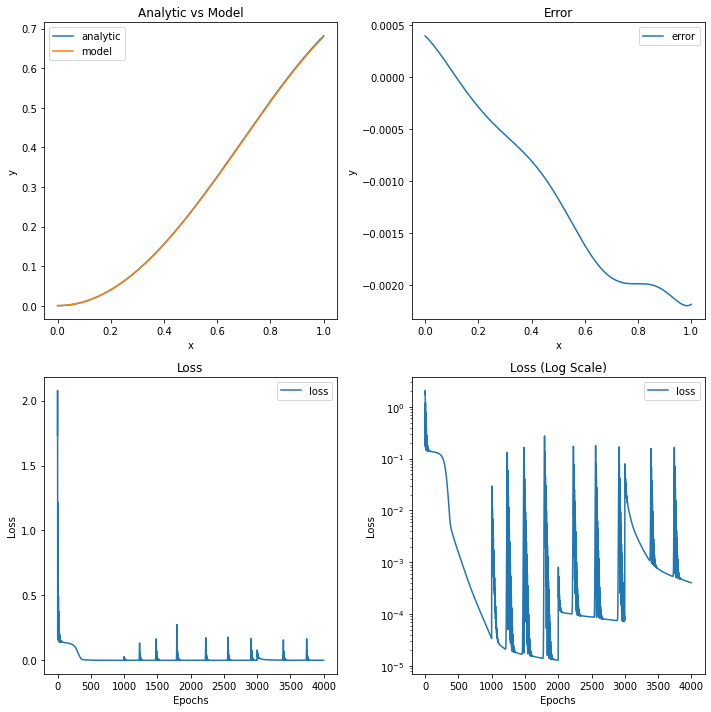

In [7]:
# --- Problem definitions ---
def equation(f, x):
    grad2_fx = calcGradients(f, x, 2)
    grad1_fx = calcGradients(f, x, 1)
    fx = f(x)
    return grad2_fx - 0.8*grad1_fx + 5*fx + x - 2

def bc_function_1(x):
    return 0.0

def bc_function_2(x):
    return 0.0

bc_functions = [bc_function_1, bc_function_2]
bc_ps = [0, 1]
bc_xs = [0.0, 0.0]

x_min = 0.0
x_max = 1.0


# Using domain extension:

# --- Solver input definitions ---
# Loss
loss_fn = LossFunction(equation, bc_ps, bc_functions, bc_xs)

# Domain specification
discretization = 0.01
# domains = [[[0.0,2.0]], [[0.0,4.0]], [[0.0,6.0]], [[0.0,8.0]], [[0.0, 10.0]]]
# domains = [[[0.0,1.0]], [[0.0,2.0]], [[0.0,3.0]], [[0.0,4.0]], [[0.0,5.0]], [[0.0,6.0]]]
domains = [[[0.0,0.25]], [[0.0,0.5]], [[0.0, 0.75]], [[0.0,1.0]]]

# Model
hidden_shapes = [100]
input_shape = 1
output_shape = 1
model = DNN(input_shape, hidden_shapes, output_shape)

# Training
num_epochs_per_domain = 1000
learning_rate = 0.01


# --- Running solver ---
# loss_data = training(model, loss_fn, dataloader, num_epochs, learning_rate)
loss_data = traininigDomainExtension(model, loss_fn, domains, discretization, num_epochs_per_domain, learning_rate)

# --- Result visualization
def equation_analytic(x):
    cos_term = 506*np.exp(2*x/5)*np.cos(11*x/5)
    sin_term = 217*np.exp(2*x/5)*np.sin(11*x/5)
    return (506 - 275*x + sin_term - cos_term) / 1375

model.eval()
x_eval = np.linspace(x_min,x_max,1000)
y_analytic = equation_analytic(x_eval)
x_eval_tensor = torch.from_numpy(x_eval).float().unsqueeze(-1)
y_model = model(x_eval_tensor).detach().flatten().numpy()

x_eval_tensor.requires_grad_(True)
print("Final evaluation loss:", loss_fn(model, x_eval_tensor))

y_error = y_model - y_analytic

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Analytic vs Model
axs[0, 0].plot(x_eval, y_analytic, label="analytic")
axs[0, 0].plot(x_eval, y_model, label="model")
axs[0, 0].legend()
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")
axs[0, 0].set_title("Analytic vs Model")

# Error
axs[0, 1].plot(x_eval, y_error, label="error")
axs[0, 1].legend()
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")
axs[0, 1].set_title("Error")

# Loss
axs[1, 0].plot(loss_data, label="loss")
axs[1, 0].legend()
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Loss")
axs[1, 0].set_title("Loss")

# Loss (Log Scale)
axs[1, 1].plot(loss_data, label="loss")
axs[1, 1].set_yscale("log")
axs[1, 1].legend()
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].set_title("Loss (Log Scale)")

plt.tight_layout()
plt.show()